In [1]:
# Initial imports
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# import hvplot.pandas as hvplot
plt.style.use('seaborn')
# !pip install ta
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)
import ta as ta
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from pathlib import Path
import intraday as it
import tensorflow as tf
import datetime
from tensorboard.plugins.hparams import api as hp


In [2]:
df=it.grab('SLB','15m')
df = df[['Close','Open','High','Low','Volume']]
#data cleaning
print(df.describe())
print(df.isna().sum())

[*********************100%***********************]  1 of 1 completed
             Close         Open         High          Low        Volume
count  1092.000000  1092.000000  1092.000000  1092.000000  1.092000e+03
mean     27.773913    27.775233    27.871387    27.677579  4.763099e+05
std       1.090594     1.093599     1.103596     1.080006  3.684690e+05
min      25.038300    24.750000    25.110001    24.520000  9.679100e+04
25%      27.059999    27.059999    27.178750    26.968750  2.523590e+05
50%      27.722500    27.730000    27.817500    27.632500  3.592245e+05
75%      28.592500    28.612501    28.700001    28.480000  5.501490e+05
max      30.330000    30.330000    30.410000    30.260000  3.065823e+06
Close     0
Open      0
High      0
Low       0
Volume    0
dtype: int64


In [3]:
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [4]:
# # Predict Closing Prices using a 10 day window of previous closing prices
window_size = 4
feature_column = 0 
target_column = 0
X, y = window_data(df, window_size, feature_column, target_column)

In [5]:
split = int(0.70 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range= (0,1))
scaler = scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
y_scaler = scaler.fit(y)
y_train = y_scaler.transform(y_train)
y_test = y_scaler.transform(y_test)

In [7]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [9]:
model = Sequential()
number_units = 20
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(1))

In [10]:
model.compile(optimizer="adam", loss='mse',  metrics=['accuracy', 'mse'])

In [11]:
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1)
hparams_callback = hp.KerasCallback(log_dir, {
    'num_layers_units': 20,
    'dropout': 0.2
})

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 4, 20)             1760      
_________________________________________________________________
dropout (Dropout)            (None, 4, 20)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 4, 20)             3280      
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 20)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2

In [13]:
model_1=model.fit(X_train, y_train, epochs=100, shuffle=False, batch_size=16, verbose=1,    validation_data=(X_test, y_test),callbacks=[tensorboard_callback, hparams_callback])

Epoch 1/100
48/48 [==============================] - 8s 57ms/step - loss: 0.2968 - accuracy: 0.0000e+00 - mse: 0.2968 - val_loss: 0.0347 - val_accuracy: 0.0031 - val_mse: 0.0347
Epoch 2/100
48/48 [==============================] - 0s 10ms/step - loss: 0.0210 - accuracy: 0.0011 - mse: 0.0210 - val_loss: 0.0126 - val_accuracy: 0.0031 - val_mse: 0.0126
Epoch 3/100
48/48 [==============================] - 0s 9ms/step - loss: 0.0325 - accuracy: 0.0011 - mse: 0.0325 - val_loss: 0.0124 - val_accuracy: 0.0031 - val_mse: 0.0124
Epoch 4/100
48/48 [==============================] - 0s 10ms/step - loss: 0.0317 - accuracy: 0.0011 - mse: 0.0317 - val_loss: 0.0136 - val_accuracy: 0.0031 - val_mse: 0.0136
Epoch 5/100
48/48 [==============================] - 0s 10ms/step - loss: 0.0302 - accuracy: 0.0011 - mse: 0.0302 - val_loss: 0.0141 - val_accuracy: 0.0031 - val_mse: 0.0141
Epoch 6/100
48/48 [==============================] - 0s 9ms/step - loss: 0.0277 - accuracy: 0.0011 - mse: 0.0277 - val_loss: 0.

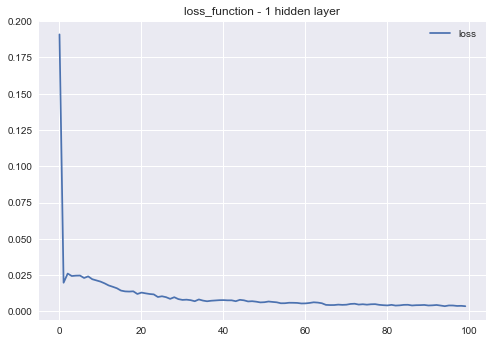

In [14]:
# Plot the train and test loss function
plt.plot(model_1.history["loss"])
plt.title("loss_function - 1 hidden layer")
plt.legend(["loss"])
plt.show()

In [15]:
model.evaluate(X_test, y_test)

11/11 [==============================] - 0s 11ms/step - loss: 0.0029 - accuracy: 0.0031 - mse: 0.0029


[0.0028973068110644817, 0.0030581040773540735, 0.0028973068110644817]

In [16]:
predicted = model.predict(X_test)

In [17]:
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [18]:
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
    }, index = df.index[-len(real_prices): ])

stocks.reset_index(inplace=True)


In [19]:
stocks.drop(columns='Datetime',inplace=True)

<AxesSubplot:title={'center':'IF This Actually Worked'}>

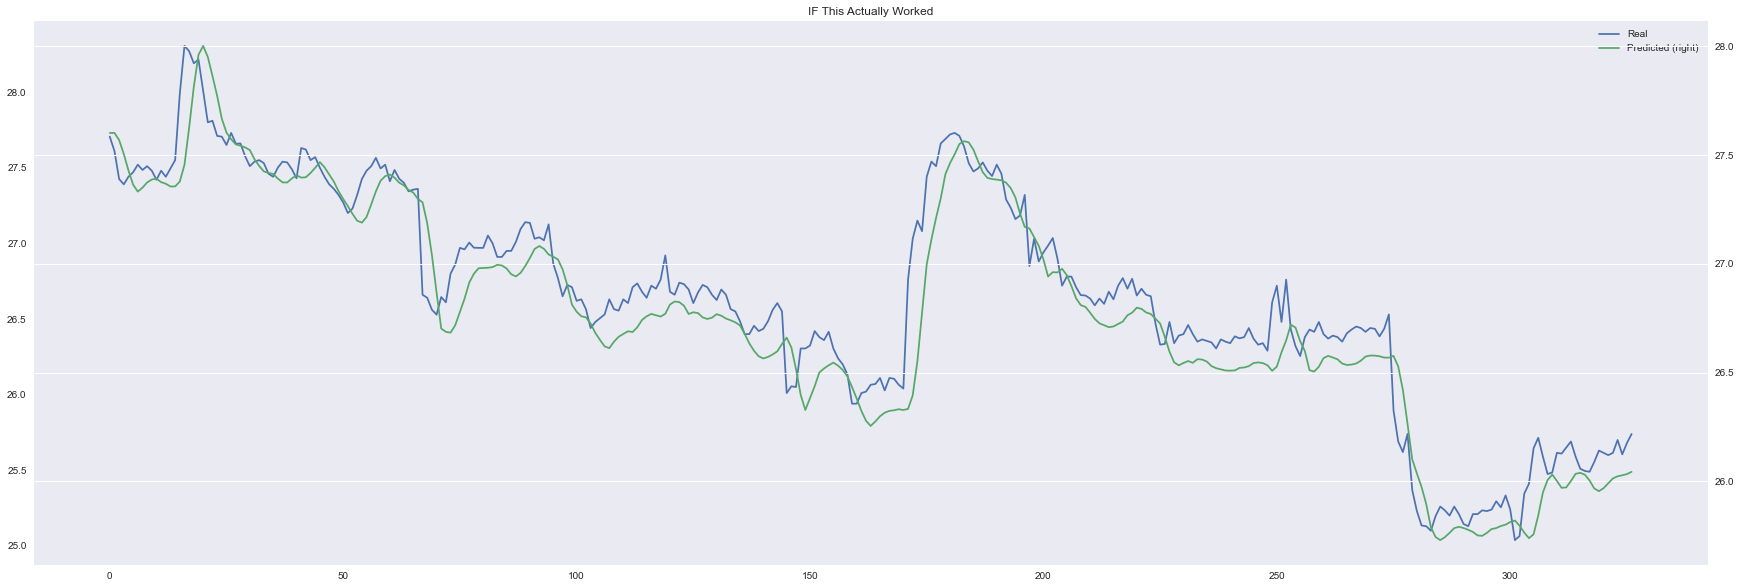

In [20]:
stocks.plot(title = "IF This Actually Worked", figsize = (30, 10),secondary_y='Predicted')

In [21]:
df.reset_index(inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1092 entries, 0 to 1091
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype                           
---  ------    --------------  -----                           
 0   Datetime  1092 non-null   datetime64[ns, America/New_York]
 1   Close     1092 non-null   float64                         
 2   Open      1092 non-null   float64                         
 3   High      1092 non-null   float64                         
 4   Low       1092 non-null   float64                         
 5   Volume    1092 non-null   int64                           
dtypes: datetime64[ns, America/New_York](1), float64(4), int64(1)
memory usage: 51.3 KB


In [22]:
df = df[['Datetime','Close']]
df.columns = ['Date','Close']
df.tail()

,Date,Close
1087,2021-04-21 14:45:00-04:00,25.615000
1088,2021-04-21 15:00:00-04:00,25.700001
1089,2021-04-21 15:15:00-04:00,25.605000
1090,2021-04-21 15:30:00-04:00,25.680000
1091,2021-04-21 15:45:00-04:00,25.740000


In [23]:
close_data = df.Close.values.reshape((-1))
look_back = 4
def predict(num_prediction, model):
    prediction_list = close_data[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
       
        out = model.predict(x)
        output=scaler.inverse_transform(out)
        prediction_list = np.append(prediction_list, output)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
def predict_dates(num_prediction):
    last_date = df['Date'].values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1,freq='15min').tolist()
    return prediction_dates

num_prediction = 1
forecast = predict(num_prediction, model)
forecast_dates = predict_dates(num_prediction)   


In [24]:
prediction = pd.DataFrame({"Predicted":forecast, "Date":forecast_dates})
prediction.

SyntaxError: invalid syntax (<ipython-input-24-ce3bba123e84>, line 2)

In [41]:
stocks.append(prediction)

,Real,Predicted,Date
0,27.389999,27.384520,NaT
1,27.440001,27.351135,NaT
2,27.469999,27.430878,NaT
3,27.520000,27.431080,NaT
4,27.485001,27.476913,NaT
...,...,...,...
320,25.700001,26.150465,NaT
321,25.660000,26.255985,NaT
322,25.650000,26.137503,NaT
0,NaN,25.733200,2021-04-21 19:45:00


In [42]:
stocks.tail()

,Real,Predicted
318,25.600000,25.987209
319,25.615000,26.064693
320,25.700001,26.150465
321,25.660000,26.255985
322,25.650000,26.137503


In [43]:
!tensorboard dev upload --logdir ./logs \
  --name "Simple LSTM RNN prediction model " \
  --description "Training results from LTSM model" \
  --one_shot

Data for the "text" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/r3nB33TQRvWfgjsDwInQ6Q/

[2021-04-21T14:11:04] Started scanning logdir.
[2021-04-21T14:11:41] Total uploaded: 3208 scalars, 8849 tensors (8.7 MB), 5 binary objects (2.2 MB)
[2021-04-21T14:11:41] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/r3nB33TQRvWfgjsDwInQ6Q/
